<a href="https://colab.research.google.com/github/shinnakayama/GLMM-course/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('ComplexUpset')
install.packages('reshape2')    # takes a few minutes

In [ ]:
library(dplyr)
library(ggplot2)
library(reshape2)
library(ComplexUpset)
library(RColorBrewer)
library(purrr)

In [6]:
load('ConflictEvents_all.RData')

# Clean up

In [8]:
data <- ce

# rename some columns
data <- data %>%
  rename(deaths = ...80) %>%
  rename(violence = ...79)

# Extract the text within the first set of parentheses from the original column names
new_colnames <- sub("^[^(]*\\(([^)]+)\\).*", "\\1", colnames(data))
colname_table <- data.frame('colname' = new_colnames, 'original' = colnames(data))

# when more than one "()", get the last one

# Function to count occurrences of "("
count_occurrences <- function(name) {
  matches <- gregexpr("\\(", name)
  count <- sum(unlist(matches) != -1)
  return(count)
}

# Count occurrences for all column names
counts <- sapply(colnames(data), count_occurrences)

# Get the indices where count > 1
indices <- unname(which(counts > 1))
indices <- indices[indices != 14]       # 14 is the first parenthesis

# get the text in the last parentheses
colname_table$colname[indices] <- sub(".*\\(([^)]+)\\)$", "\\1", colnames(data)[indices])

# add description
colname_table$description <- sapply(strsplit(colname_table$original, colname_table$colname), function(x) x[[1]])
colname_table$description <- sub(" \\($", "", colname_table$description)

colname_table$description[colname_table$colname == 'access_space'] <- 'Access to space'

# rename columns
colnames(data) <- colname_table$colname

# change country name
data$country[data$iso3_code=='COG'] <- 'Republic of the Congo'
data$country[data$iso3_code=='MYT'] <- 'Mayotte & Îles Éparses'
data$country[data$iso3_code=='STP'] <- 'São Tomé & Príncipe'
data$country[data$iso3_code=='GNB'] <- 'Guinea-Bissau'
data$country[data$iso3_code=='STP'] <- 'São Tomé & Príncipe'
data$country[data$iso3_code=='CPV'] <- 'Cabo Verde'
data$country[data$iso3_code=='REU'] <- 'Réunion'
data$country[data$iso3_code=='CIV'] <- 'Côte d\'Ivoire'


# drop conf_event_id
data <- subset(data, select = -c(conf_event_id))

# drop conflict event pre-2008 & > 2018
data <- data[data$star_yr != 'pre-2008',]
data$star_yr <- as.integer(data$star_yr)
data <- data[data$star_yr <= 2018,]

Aggregate NGO, government, and industrial non-fisher

In [9]:
# convert to 0/1
x <- c('intl_ngo', 'local_ngo', 'natl_ngo', 'intl_govt', 'loc_govt', 'ind_non_liv', 'ind_living_res')
data <-  data %>%
  mutate(across(all_of(x), ~ifelse(is.na(.x) | .x != 1, 0, .x)))

# aggregate
data$ngo <- rowSums(data[, c('intl_ngo', 'local_ngo', 'natl_ngo')])
data$govt <- rowSums(data[, c('intl_govt', 'loc_govt')])
data$ind_non_fish <- rowSums(data[, c('ind_non_liv', 'ind_living_res')])

# convert to 0/1 based on the sum
data <- data %>%
  mutate(across(all_of(c('ngo', 'govt', 'ind_non_fish')), ~ifelse(.x > 0, 1, 0)))

Convert to 0 / 1

In [10]:
# convert to 0 / 1
conflict_type <- c('access_space', 'use_space', 'access_res', 'use_res', 'benef_dist_type', 'piracy')

actor_type_original <- c("subs_fisher", "ind_fishers", "fish_trad",
             "subs_living_res", "develop", "comm_org", "worker_union",
              "pirates", "state_enf", "intl_multi_bod",
              'intl_ngo', 'local_ngo', 'natl_ngo', 'intl_govt', 'loc_govt', 'ind_non_liv', 'ind_living_res')

actor_type_aggregated <- c("ngo", "govt", "subs_fisher", "ind_fishers", "fish_trad",
             "subs_living_res", "ind_non_fish", "develop", "comm_org", "worker_union",
              "pirates", "state_enf", "intl_multi_bod")

stakeholder_type <- c('same_sec', 'diff_sec', 'btw_users_gov', 'btw_gov')

resolution_type <- c('ev_stalemate', 'ev_res', 'ev_unres')

prox_driver_type <- c('benef_dist_driv', 'acut_food_short', 'nat_dis', 'trad_v_new', 'bord_disp_prox',
               'inad_gov_prox', 'lack_reg_prox', 'pol_insta_prox', 'res_cond_hum_prox',
               'res_cond_nonhum_prox', 'ill_res_use_prox', 'iuu_fish_prox', 'piracy_prox', 'plan_dev')

dist_driver_type <- c('poverty', 'soc_eco_ineq', 'food_insec_dist', 'clim_chang',
                    'bord_disp_dist', 'ethnic_div_dist', 'cons_dem', 'pop_inc',
                    'inad_gov_dist', 'pol_insta_dist', 'poor_res_hum_dist',
                    'poor_res_no_hum_dist', 'marit_crime_dist', 'ill_res_use_dist',
                    'iuu_fish_dist', 'piracy_dist')


data$ev_stalemate <- ifelse(data$ev_stalemate == 'Y', 1, 0)
data$ev_res <- ifelse(data$ev_res == 'Y', 1, 0)
data$ev_unres <- ifelse(data$ev_unres == 'Y', 1, 0)

x <- c(conflict_type, actor_type_original, actor_type_aggregated, resolution_type, prox_driver_type, dist_driver_type)

data <- data %>%
  mutate(across(all_of(x), ~ifelse(is.na(.x) | .x != 1, 0, .x)))

# total conflict events
data$total_conflict <- rowSums(data[conflict_type])

# Plot occurrences by conflict type

In [ ]:
# all conflicts including piracy-only
foo <- data %>%
    select(all_of(conflict_type)) %>%
    filter(rowSums(.) != 0) # remove conflict without conflict types

pdf('upset_plot.pdf', width=12, height=5)
upset(foo, conflict_type, name='Conflict type(s)', width_ratio=0.15)
dev.off()

png 
  2

In [ ]:
data %>%
  select(all_of(conflict_type)) %>%
  reframe(conflict = conflict_type, count = colSums(.), total = nrow(.)) %>%
  mutate(prop = count/total)

conflict,count,total,prop
<chr>,<dbl>,<int>,<dbl>
access_space,456,1082,0.4214418
use_space,193,1082,0.1783734
access_res,423,1082,0.3909427
use_res,231,1082,0.2134935
benef_dist_type,134,1082,0.1238447
piracy,137,1082,0.1266174


# Plot occurrences by country

In [ ]:
# count by country x conflict type, including piracy-only conflicts
foo <- data %>%
    group_by(iso3_code, country) %>%
    summarize(across(all_of(conflict_type), ~sum(. == 1), .names = "{.col}"), .groups = 'drop')

# add Mauritius (no conflict observation)
foo <- rbind(foo, c('MAU', 'Mauritius',0,0,0,0,0,0))
foo <- foo %>% mutate_at(conflict_type, as.integer)

# add total conflict
bar <- data %>%
    group_by(country) %>%
    summarize(total_conflict = sum(total_conflict))

summary <- bar %>%
    full_join(foo, by='country') %>%
    mutate(total_conflict = coalesce(total_conflict, 0)) %>%
    mutate(country2 = paste(country, ' (', total_conflict, ')', sep=''))

# wide to long
summary <- melt(summary, id.vars=c('iso3_code', 'country2'), measure.vars=conflict_type,
    variable.name='conflict_type', value.name='count')


# reorder conflict type
summary$conflict_type <- factor(summary$conflict_type, levels = rev(c('access_space', 'access_res', 'use_res', 'use_space', 'piracy', 'benef_dist_type')))

# reorder country2
iso3_order <- c('MRT', 'SEN', 'CPV', 'GMB', 'GNB', 'GUI', 'SLE', 'LBR', 'CIV', 'GHA',
    'TGO', 'BEN', 'NGA', 'CMR', 'GNQ', 'STP', 'GAB', 'COG', 'ANG', 'NAM', 'ZAF',
    'MOZ', 'MAG', 'REU', 'MUS', 'MYT', 'COM', 'TZA', 'KEN', 'SOM', 'SYC', 'DJI', 'ERI', 'SDN')

summary$iso3_code <- factor(summary$iso3_code, levels = iso3_order)

country_order <- summary$country2[order(match(summary$iso3_code, iso3_order))]
country_order <- country_order[!duplicated(country_order)]
summary$country2 <- factor(summary$country2, levels = country_order)


# plot
plot <- ggplot(summary, aes(y = conflict_type, x = country2, fill = as.integer(count))) +
    geom_tile(width = 0.9, height = 0.9) +
    labs(y = 'Conflict type', x = 'County/territory') +
    scale_fill_gradient(low = '#ffffff', high = '#ff0000', name = 'Count') +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.key.size = unit(0.2, "inch"))


pdf('country.pdf', width=9, height=3.1)
plot
dev.off()

png 
  2

Number of conflicts and countries

In [ ]:
nrow(data)
length(unique(data$country))

[1] 1082

[1] 33

Number of conflicts per country

In [ ]:
foo <- data %>%
  group_by(country) %>%
  summarize(count = n())

range(foo$count)

[1]   1 140

Number of combination

In [ ]:
foo <- data %>%
    group_by(across(all_of(x))) %>%
    summarize(count = n(), .groups = 'drop')

nrow(foo)
nrow(foo)/nrow(data)

[1] 856

[1] 0.7911275

Time series by country

In [ ]:
install.packages("car")    # takes several minutes
library(car)
library(lme4)

In [ ]:
# total conflict events by country x year
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    group_by(country, star_yr) %>%
    summarize(count = n(), .groups = 'drop')

# Create a template for all combinations of country and year
template <- expand.grid(
  country = unique(foo$country),
  star_yr = seq(2008, 2018)
)

# Merge the template with the original data and fill missing counts with 0
bar <- template %>%
  left_join(foo, by = c("country", "star_yr")) %>%
  mutate(count = coalesce(count, 0))

# fit and test
bar$yr2 <- bar$star_yr - mean(bar$star_yr)
fit <- glmer(count ~ yr2 + (1|country), data=bar, family=poisson)

Anova(fit, type = 3)

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),8.818582,1,0.002981784
yr2,1.544066,1,0.214013608


Individual country

In [ ]:
install.packages("emmeans")
install.packages("broom")
library(emmeans)
library(broom)

In [ ]:
fit <- glm(count ~ yr2 * country, data=bar, family=poisson)
emt <- emtrends(fit, ~country, var = "yr2")

# Display the summary of the tests
out <- summary(emt, infer = TRUE)

increase <- out[out$p.value < 0.05 & out$yr2.trend > 0,]
increase$rate <- exp(increase$yr2.trend) - 1
increase[order(increase$yr2.trend),]

decrease <- out[out$p.value < 0.05 & out$yr2.trend < 0,]
decrease$rate <- exp(decrease$yr2.trend) - 1
decrease[order(decrease$yr2.trend),]

,country,yr2.trend,SE,df,asymp.LCL,asymp.UCL,z.ratio,p.value,rate
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24,Réunion,0.1069539,0.04027883,Inf,0.028008848,0.1858990,2.655338,0.007922901,0.1128830
15,Kenya,0.1244410,0.06148555,Inf,0.003931498,0.2449504,2.023906,0.042979844,0.1325152
30,South Africa,0.1263725,0.04736766,Inf,0.033533563,0.2192114,2.667906,0.007632558,0.1347047
16,Liberia,0.1532896,0.04526954,Inf,0.064562917,0.2420163,3.386153,0.000708799,0.1656625
20,Mozambique,0.1990080,0.09819923,Inf,0.006541039,0.3914750,2.026574,0.042706012,0.2201917
3,Cabo Verde,0.2457316,0.11814461,Inf,0.014172427,0.4772908,2.079922,0.037532661,0.2785564
13,Guinea,0.2829635,0.11816477,Inf,0.051364817,0.5145622,2.394652,0.016636143,0.3270567
11,Gambia,0.3101201,0.14379947,Inf,0.028278307,0.5919619,2.156615,0.031035677,0.3635888


,country,yr2.trend,SE,df,asymp.LCL,asymp.UCL,z.ratio,p.value,rate
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,Côte d'Ivore,-0.20212907,0.06380430,Inf,-0.3271832,-0.07707493,-3.167954,0.001535160,-0.18301053
29,Somalia,-0.11171076,0.03716465,Inf,-0.1845521,-0.03886939,-3.005834,0.002648535,-0.10569711
22,Nigeria,-0.09809398,0.04470921,Inf,-0.1857224,-0.01046553,-2.194044,0.028232254,-0.09343630
26,Senegal,-0.07875352,0.02773066,Inf,-0.1331046,-0.02440242,-2.839944,0.004512151,-0.07573229


% Access to resource or space

In [ ]:
nrow(data[data$access_res == 1 | data$access_space == 1,])/nrow(data) * 100
nrow(data[data$access_space == 1,])/nrow(data) * 100
nrow(data[data$access_res == 1,])/nrow(data) * 100

[1] 64.32532

[1] 42.14418

[1] 39.09427

Purely piracy conflict

In [ ]:
nrow(data[data$total_conflict==1 & data$piracy==1,])
nrow(data[data$total_conflict==1 & data$piracy==1,])/nrow(data) * 100

[1] 120

[1] 11.09057

Piracy-only by country

In [ ]:
data %>%
    filter(piracy == 1 & total_conflict == 1) %>%
    group_by(country) %>%
    summarize(n_piracy_only = n()) %>%
    arrange(desc(n_piracy_only))

country,n_piracy_only
<chr>,<int>
Somalia,62
Nigeria,19
Seychelles,12
Cameroon,9
Kenya,5
Ghana,4
Madagascar,4
Guinea,1
Mauritania,1


Any piracy by country

In [ ]:
data %>%
    filter(piracy == 1) %>%
    group_by(country) %>%
    summarize(n_piracy = n()) %>%
    arrange(desc(n_piracy))

country,n_piracy
<chr>,<int>
Somalia,70
Nigeria,25
Seychelles,13
Cameroon,9
Ghana,5
Kenya,5
Madagascar,4
Eritrea,1
Guinea,1


Countries that stand out

In [ ]:
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate(total_conflict = ifelse(total_conflict > 1, 1, total_conflict)) %>%
    mutate(access = ifelse(access_res == 1 | access_space == 1, 1, 0)) %>%
    mutate(use = ifelse(use_res == 1 | use_space == 1, 1, 0)) %>%
    group_by(country) %>%
    summarize(count = sum(access), total = sum(total_conflict)) %>%    # change
    mutate(percent = round(count/total * 100)) %>%
    arrange(desc(count))

country,count,total,percent
<chr>,<dbl>,<dbl>,<dbl>
Senegal,116,133,87
Somalia,66,68,97
Mauritania,59,65,91
Ghana,46,48,96
Liberia,46,56,82
South Africa,37,49,76
Namibia,35,59,59
Madagascar,28,31,90
Réunion,27,66,41


Access to resource vs. access to space

In [ ]:
# any access-related
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate(access = ifelse(access_res == 1 | access_space == 1, 1, 0)) %>%
    group_by(country) %>%
    summarize(n_access = sum(access))

# access to resource
bar <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    group_by(country) %>%
    summarize(n_access_res = sum(access_res))

# access to space
baz <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    group_by(country) %>%
    summarize(n_access_space = sum(access_space))

# merge
foo %>%
    left_join(bar, by='country') %>%
    left_join(baz, by='country') %>%
    mutate(ratio = n_access_space/(n_access_res + n_access_space)) %>%
    filter(n_access >= 10) %>%
    filter(ratio <=0.2 | ratio >= 0.8)

country,n_access,n_access_res,n_access_space,ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Liberia,46,6,44,0.88000000
Namibia,35,35,4,0.10256410
Nigeria,19,18,2,0.10000000
Seychelles,25,5,21,0.80769231
Sudan,15,0,15,1.00000000
Tanzania,23,23,1,0.04166667


change of each conflict type over year

In [ ]:
# variable of interest
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(benef_dist_type == 1) %>%      # variable of interest
    group_by(country, star_yr) %>%
    summarize(n_x = n(), .groups = 'drop')

# Create a template for all combinations of country and year
template <- expand.grid(
  country = unique(foo$country),
  star_yr = seq(2008, 2018)
)

# Merge the template with the original data and fill missing counts with 0
bar <- template %>%
  left_join(foo, by = c("country", "star_yr")) %>%
  mutate(n_x = coalesce(n_x, 0))

# fit the model and test
bar$yr2 <- bar$star_yr - mean(bar$star_yr)
fit <- glmer(n_x ~ yr2 + (1|country), data=bar, family=poisson)
Anova(fit, type = 3)

# multiplicative rate of change
exp(fixef(fit)[2])

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),18.147887,1,0.0000204396
yr2,1.247334,1,0.2640623061


yr2 
0.9705377

Change of conflict events over time by conflict type, for each country

In [ ]:
fit <- glm(n_x ~ yr2 * country, data=bar, family=poisson)
emt <- emtrends(fit, ~country, var = "yr2")

# Display the summary of the tests
out <- summary(emt, infer = TRUE)
out <- out[out$p.value < 0.05 & !is.na(out$p.value),]
out$rate <- exp(out$yr2.trend) - 1
out

Warning message:
“glm.fit: fitted rates numerically 0 occurred”


,country,yr2.trend,SE,df,asymp.LCL,asymp.UCL,z.ratio,p.value,rate
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,Ghana,-0.4710139,0.2313373,Inf,-0.92442675,-0.01760109,-2.036048,0.04174553,-0.3756311
14,Nigeria,0.3784371,0.1833727,Inf,0.01903327,0.73784097,2.063760,0.03904052,0.4600010
18,Senegal,-0.1423890,0.0544561,Inf,-0.24912101,-0.03565703,-2.614749,0.00892931,-0.1327162


# Illegal actvities

In [ ]:
foo <- data
foo <- data[!(data$piracy==1 & data$total_conflict==1),]
nrow(foo[foo$illegal_act == 'Y', ])/nrow(foo)

[1] 0.502079

IUU fishing

In [51]:
illegal_type <- c('iuu_fish', 'ill_spa_acc', 'ill_spa_use', 'ill_res_acc', 'ill_res_use', 'gear_destr', 'infrast_destr')

foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    mutate(illegal_all = rowSums(across(all_of(illegal_type))))

nrow(foo[foo$iuu_fish > 0, ])/nrow(foo)

[1] 0.3814969

Country with IUU fishing

In [ ]:
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    mutate(illegal_all = rowSums(across(all_of(illegal_type))))

foo %>%
    group_by(country) %>%
    summarize(count = sum(iuu_fish)) %>%
    arrange(desc(count))

country,count
<chr>,<dbl>
Senegal,46
Somalia,36
Liberia,30
Madagascar,24
Mauritania,23
Ghana,22
Tanzania,20
Sierra Leone,16
Cameroon,14


Time series of IUU fishing in Senegal

In [ ]:
senegal <- foo %>%
    filter(country=='Senegal') %>%
    group_by(star_yr) %>%
    summarize(count = n())

senegal

star_yr,count
<int>,<int>
2008,17
2009,8
2010,10
2011,26
2012,15
2013,13
2014,22
2015,5
2016,5


In [ ]:
yr2 <- senegal$star_yr - mean(senegal$star_yr)
fit <- glm(count ~ yr2, data=senegal, family=poisson)

Anova(fit, type = 3)
exp(coef(fit)[2]) - 1

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
yr2,8.217556,1,0.004148704


yr2 
-0.07573229

IUU fishing vs. piracy

In [11]:
jaccard <- function(df, x1, x2) {
    set1 <- nrow(df[df[x1]==1 & df[x2]==1,])
    set2 <- nrow(df[df[x1]==1 | df[x2]==1,])
    return (set1/set2)
}

In [14]:
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .))

obs <- jaccard(foo, 'piracy', 'iuu_fish')

set.seed(1212)
perm <- c()
for(i in 1:1000){
    bar <- foo
    bar$iuu_fish <- sample(bar$iuu_fish, )
    perm[i] <- jaccard(bar, 'piracy', 'iuu_fish')
}

p <- (min(length(perm[perm > obs]), length(perm[perm < obs])) + 1) / (length(perm) + 1)

obs
p
sign(obs - mean(perm))

[1] 0.01587302

[1] 0.2897103

[1] -1

By country

In [44]:
# including piracy-only conflicts
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .))

# countries that have both `piracy` and `iuu_fish`
bar <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    group_by(country) %>%
    summarize(n_piracy = sum(piracy), n_iuu_fish = sum(iuu_fish)) %>%
    filter(n_piracy > 0 & n_iuu_fish > 0)


summary <- data.frame()
for (x in bar$country){
    bar <- foo[foo$country==x,]

    obs <- jaccard(bar, 'piracy', 'iuu_fish')

    set.seed(1212)
    perm <- c()
    for(i in 1:1000){
        bar <- foo
        bar$iuu_fish <- sample(bar$iuu_fish, )
        perm[i] <- jaccard(bar, 'piracy', 'iuu_fish')
    }

    p <- (min(length(perm[perm > obs]), length(perm[perm < obs])) + 1) / (length(perm) + 1)

    summary <- rbind(summary, c(x, obs, p, sign(obs - mean(perm))))
}

colnames(summary) <- c('country', 'stat', 'p', 'sign')
summary

country,stat,p,sign
<chr>,<chr>,<chr>,<chr>
Ghana,0,0.000999000999000999,-1
Nigeria,0.0666666666666667,0.000999000999000999,1
Seychelles,0,0.000999000999000999,-1
Somalia,0.128205128205128,0.000999000999000999,1


In [43]:
colnames(summary) <- c('country', 'stat', 'p', 'sign')
p.adjust(summary$p, method = 'bonferroni')

[1] 0.003996004 0.003996004 0.003996004 0.003996004

In [15]:
# including piracy-only conflicts
foo <- data %>%
    # filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .))

obs <- jaccard(foo, 'piracy', 'iuu_fish')

set.seed(1212)
perm <- c()
for(i in 1:1000){
    bar <- foo
    bar$iuu_fish <- sample(bar$iuu_fish, )
    perm[i] <- jaccard(bar, 'piracy', 'iuu_fish')
}

p <- (min(length(perm[perm > obs]), length(perm[perm < obs])) + 1) / (length(perm) + 1)

obs
p
sign(obs - mean(perm))

[1] 0.01405622

[1] 0.000999001

[1] -1

by country

In [25]:
# including piracy-only conflicts
country <- data %>%
    # filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    group_by(country) %>%
    summarize(n_piracy = sum(piracy), n_iuu_fish = sum(iuu_fish)) %>%
    filter(n_piracy > 0 & n_iuu_fish > 0) %>%
    select(country)

country

country
<chr>
Cameroon
Ghana
Guinea
Kenya
Madagascar
Mauritania
Mozambique
Nigeria
Seychelles


In [38]:
# including piracy-only conflicts
foo <- data %>%
    # filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .))

# countries that have both `piracy` and `iuu_fish`
bar <- data %>%
    # filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    group_by(country) %>%
    summarize(n_piracy = sum(piracy), n_iuu_fish = sum(iuu_fish)) %>%
    filter(n_piracy > 0 & n_iuu_fish > 0)


summary <- data.frame()
for (x in bar$country){
    bar <- foo[foo$country==x,]

    obs <- jaccard(bar, 'piracy', 'iuu_fish')

    set.seed(1212)
    perm <- c()
    for(i in 1:1000){
        bar <- foo
        bar$iuu_fish <- sample(bar$iuu_fish, )
        perm[i] <- jaccard(bar, 'piracy', 'iuu_fish')
    }

    p <- (min(length(perm[perm > obs]), length(perm[perm < obs])) + 1) / (length(perm) + 1)

    summary <- rbind(summary, c(x, obs, p, sign(obs - mean(perm))))
}

summary

Piracy & IUU fishing by country

In [ ]:
# piracy == 1
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    filter(piracy == 1) %>%
    group_by(country) %>%
    summarize(n_piracy = n())

# iuu_fish == 1
bar <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    filter(iuu_fish == 1) %>%
    group_by(country) %>%
    summarize(n_iuu_fish = n())

# merge
full_join(foo, bar, by = 'country') %>%
    select(country, n_piracy, n_iuu_fish) %>%
    mutate(n_iuu_fish = coalesce(n_iuu_fish, 0)) %>%
    mutate(n_piracy = coalesce(n_piracy, 0)) %>%
    arrange(desc(n_piracy))

country,n_piracy,n_iuu_fish
<chr>,<dbl>,<dbl>
Somalia,8,36
Nigeria,6,10
Eritrea,1,0
Ghana,1,22
Seychelles,1,12
Angola,0,4
Benin,0,1
Cabo Verde,0,6
Cameroon,0,14


Correlation between piracy and IUU fishing over time, proportion to the total conflicts

In [ ]:
# Create a template for all combinations of country and year
template <- expand.grid(
    country = unique(data$country),
    star_yr = seq(2008, 2018)
)

# all conflict events
all_events <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    group_by(country, star_yr) %>%
    summarize(n_all = n(), .groups = 'drop')

# IUU fishing
iuu_fish <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    mutate_at(illegal_type, ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    filter(iuu_fish == 1) %>%
    group_by(country, star_yr) %>%
    summarize(n_iuu_fish = n(), .groups = 'drop')

# piracy
piracy <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(piracy == 1) %>%
    group_by(country, star_yr) %>%
    summarize(n_piracy = n(), .groups = 'drop')


# Merge the template with the original data and fill missing counts with 0
foo <- template %>%
    left_join(all_events, by = c("country", "star_yr")) %>%
    left_join(iuu_fish, by = c("country", "star_yr")) %>%
    left_join(piracy, by = c("country", "star_yr")) %>%
    mutate(n_all = coalesce(n_all, 0)) %>%
    mutate(n_iuu_fish = coalesce(n_iuu_fish, 0)) %>%
    mutate(n_piracy = coalesce(n_piracy, 0))

# add proportion
foo <- foo %>%
    mutate(p_iuu_fish = n_iuu_fish/n_all) %>%
    mutate(p_piracy = n_piracy/n_all)

# drop NA rows
foo <- foo %>%
  filter(!is.na(p_iuu_fish)) %>%
  filter(!is.na(p_piracy))


# summarize
summary <- data.frame()

for(x in unique(foo$country)) {

    bar <- foo[foo$country == x,]

    if(nrow(bar) > 1 & var(bar$p_iuu_fish) > 0 & var(bar$p_piracy) > 0){
        fit <- suppressWarnings(cor.test(bar$p_iuu_fish, bar$p_piracy))
        summary <- rbind(summary, c(x, fit$estimate, fit$statistic, fit$parameter, fit$p.value))
    }
}


colnames(summary) <- c('country', 'cor', 't', 'df', 'p')

# Bonferroni correction
summary$adjusted.p <- p.adjust(summary$p, method = "bonferroni")
summary

country,cor,t,df,p,adjusted.p
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Ghana,-0.0694376487224849,-0.208816969047054,9,0.839240724651458,1
Nigeria,0.130475840146527,0.372223360871,8,0.719393574764215,1
Seychelles,-0.281248416469319,-0.828951270107502,8,0.431168097482639,1
Somalia,-0.167187082512632,-0.508721404869957,9,0.623183375544997,1


# Violence

In [45]:
foo <- data
foo <- data[!(data$piracy==1 & data$total_conflict==1),]

nrow(foo[foo$violence==1,])/nrow(foo)   # threat
nrow(foo[foo$violence==2,])/nrow(foo)   # induries
nrow(foo[foo$violence==3,])/nrow(foo)   # deaths

[1] 0.03014553

[1] 0.04158004

[1] 0.02286902

Violence vs. illegal type

In [106]:
# contingency table
data$violence0 <- ifelse(data$violence == 0, 1, 0)
data$violence1 <- ifelse(data$violence == 1, 1, 0)
data$violence2 <- ifelse(data$violence == 2, 1, 0)
data$violence3 <- ifelse(data$violence == 3, 1, 0)

violence_type <- c('violence0', 'violence1', 'violence2', 'violence3')

df_list <- map(violence_type, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(!is.na(violence)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(illegal_type)) %>%
    mutate(across(everything(), ~ifelse(is.na(.) | . != 1, 0, .))) %>%
    reframe(var = illegal_type, count = colSums(.)))

df <- reduce(df_list, full_join, by = 'var')
df <- as.data.frame(df)
df <- df %>% select(-var)
colnames(df) <- violence_type

chisq.test(df)

Warning message in chisq.test(df):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  df
X-squared = 77.952, df = 18, p-value = 1.951e-09


Violence vs. conflict type

In [102]:
# contingency table
df_list <- map(violence_type, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(!is.na(violence)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(conflict_type)) %>%
    reframe(var = conflict_type, count = colSums(.)))

df <- reduce(df_list, full_join, by = 'var')
df <- as.data.frame(df)
df <- df %>% select(-var)
colnames(df) <- violence_type

chisq.test(df)

Warning message in chisq.test(df):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  df
X-squared = 83.045, df = 15, p-value = 1.929e-11


# Intensity

In [46]:
intensity_type <- c('mil_pol_neg', 'diplom', 'leg_natl', 'leg_intl', 'verb_disc', 'piracy_intensity')

# non-violent conflict
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(violence == 0 | is.na(violence)) %>%
    select(all_of(intensity_type)) %>%
    mutate(across(everything(), ~ifelse(is.na(.) | . != 1, 0, .)))

# proportion
nrow(foo[foo$mil_pol_neg==1,])/nrow(foo)
nrow(foo[foo$diplom==1,])/nrow(foo)
nrow(foo[foo$leg_natl==1,])/nrow(foo)
nrow(foo[foo$leg_intl==1,])/nrow(foo)
nrow(foo[foo$verb_disc==1,])/nrow(foo)
nrow(foo[foo$piracy_intensity==1,])/nrow(foo)

[1] 0.3284091

[1] 0.08522727

[1] 0.1

[1] 0.02727273

[1] 0.5954545

[1] 0.009090909

Military vs. IUU fishing/piracy

In [47]:
# military
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(mil_pol_neg, iuu_fish, piracy) %>%
    mutate(across(everything(), ~ifelse(is.na(.) | . != 1, 0, .))) %>%
    filter(mil_pol_neg == 1)

# proportion of IUU fishing/piracy
nrow(foo[foo$iuu_fish==1 | foo$piracy==1,])/nrow(foo)

[1] 0.7337278

Violence vs. IUU fishing/piracy

In [48]:
# violent conflict
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(violence > 0) %>%
    select(iuu_fish, piracy) %>%
    mutate(across(everything(), ~ifelse(is.na(.) | . != 1, 0, .)))

# proportion of piracy
nrow(foo[foo$piracy==1,])/nrow(foo)

# proportion of IUU fishing/piracy
nrow(foo[foo$iuu_fish==1 | foo$piracy==1,])/nrow(foo)

[1] 0.1097561

[1] 0.5121951

Verbal discord vs. conflict type

In [49]:
data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(verb_disc, all_of(conflict_type)) %>%
    mutate(across(everything(), ~ifelse(is.na(.) | . != 1, 0, .))) %>%
    filter(verb_disc == 1) %>%
    select(-verb_disc) %>%
    reframe(var = conflict_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total)

var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
access_space,246,569,0.43233743
use_space,152,569,0.26713533
access_res,259,569,0.45518453
use_res,147,569,0.25834798
benef_dist_type,118,569,0.20738137
piracy,10,569,0.01757469


Intensity vs. illegal type

Intensity vs. conflict type

# Driver

Proximate driver

In [ ]:
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(prox_driver_type)) %>%
    reframe(var = prox_driver_type, count = colSums(.), total = nrow(.)) %>%
    mutate(percent = count/total * 100) %>%
    arrange(desc(count))
foo$percent <- round(foo$percent, 1)
foo

var,count,total,percent
<chr>,<dbl>,<int>,<dbl>
iuu_fish_prox,303,962,31.5
benef_dist_driv,201,962,20.9
lack_reg_prox,100,962,10.4
res_cond_hum_prox,84,962,8.7
plan_dev,64,962,6.7
inad_gov_prox,35,962,3.6
ill_res_use_prox,27,962,2.8
bord_disp_prox,19,962,2.0
acut_food_short,10,962,1.0


bar chart

In [ ]:
p <- ggplot(foo, aes(x = reorder(var, percent), y = percent)) +
  geom_bar(stat = "identity", color = "black") +
  ylim(0, 33) +
  coord_flip() +
  labs(y = "Involvement (%)", x = NULL) +
  theme_minimal()

ggsave("prox_driver.pdf", p, width = 8, height = 6, units = "in")

spider chart

In [ ]:
install.packages('fmsb')
library(fmsb)

In [ ]:
# total number of conflict by conflict types
total <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(conflict_type))


# driver by confict types
df_list <- map(conflict_type, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(prox_driver_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = prox_driver_type, count = colSums(.)))


df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- prox_driver_type
df <- df %>% select(-var)
colnames(df) <- conflict_type


df <- sweep(df, 2, colSums(total), `/`)
df <- round(df * 100, 1)
df

,access_space,use_space,access_res,use_res,benef_dist_type,piracy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
benef_dist_driv,23.5,16.1,25.3,20.3,85.8,17.6
acut_food_short,1.3,1.0,1.9,0.4,1.5,0.0
nat_dis,0.2,0.0,0.0,0.0,0.0,0.0
trad_v_new,0.9,0.5,0.7,0.0,0.7,0.0
bord_disp_prox,3.9,1.6,1.7,0.0,0.0,0.0
inad_gov_prox,3.9,0.5,4.7,3.5,6.7,0.0
lack_reg_prox,13.8,2.6,12.5,8.7,17.2,0.0
pol_insta_prox,0.0,0.0,0.2,0.0,0.0,0.0
res_cond_hum_prox,4.4,30.1,4.5,9.1,5.2,0.0


In [ ]:
# drivers of interest
foo <- df[c('iuu_fish_prox', 'benef_dist_driv', 'lack_reg_prox', 'res_cond_hum_prox'),]


# add min and max
foo  <- rbind(rep(0, 6), foo)
foo  <- rbind(rep(1, 6), foo)

foo <- foo * 100

# color
mycol = c('red', 'blue', 'orange', 'purple')

create_beautiful_radarchart <- function(data, color = "#00AFBB",
                                        vlabels = colnames(data), vlcex = 0.7,
                                        caxislabels = NULL, title = NULL, ...){
  radarchart(
    data, axistype = 1,
    # Customize the polygon
    pcol = color, plwd = 2, plty = 1,
    # Customize the grid
    cglcol = "grey", cglty = 1, cglwd = 0.8,
    # Customize the axis
    axislabcol = "grey",
    # Variable labels
    vlcex = vlcex, vlabels = vlabels,
    caxislabels = caxislabels, title = title, ...
  )
}


pdf("prox_driver_radar_chart.pdf", width = 8, height = 8)

# Reduce plot margin using par()
op <- par(mar = c(1, 2, 2, 2))
# Create the radar charts
create_beautiful_radarchart(
  data = foo,
  color = mycol
)
# Add an horizontal legend
legend(
  x = "bottom", legend = rownames(foo[-c(1,2),]), horiz = TRUE,
  bty = "n", pch = 20 , col = mycol,
  text.col = "black", cex = 1, pt.cex = 1.5
  )

par(op)

dev.off()

png 
  2

Distal driver

In [ ]:
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(dist_driver_type)) %>%
    reframe(var = dist_driver_type, count = colSums(.), total = nrow(.)) %>%
    mutate(percent = count/total * 100) %>%
    arrange(desc(count))
foo$percent <- round(foo$percent, 1)
foo

var,count,total,percent
<chr>,<dbl>,<int>,<dbl>
inad_gov_dist,309,962,32.1
iuu_fish_dist,297,962,30.9
poor_res_hum_dist,268,962,27.9
poverty,96,962,10.0
bord_disp_dist,32,962,3.3
ill_res_use_dist,32,962,3.3
piracy_dist,31,962,3.2
clim_chang,23,962,2.4
food_insec_dist,22,962,2.3


Bar chart

In [ ]:
p <- ggplot(foo, aes(x = reorder(var, percent), y = percent)) +
  geom_bar(stat = "identity", color = "black") +
  ylim(0, 33) +
  coord_flip() +
  labs(y = "Involvement (%)", x = NULL) +
  theme_minimal()

ggsave("distal_driver.pdf", p, width = 8, height = 6, units = "in")

Spider chart

In [ ]:
# total number of conflict by conflict types
total <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(conflict_type))


# driver by confict types
df_list <- map(conflict_type, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(dist_driver_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = dist_driver_type, count = colSums(.)))


df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- dist_driver_type
df <- df %>% select(-var)
colnames(df) <- conflict_type


df <- sweep(df, 2, colSums(total), `/`)
df

,access_space,use_space,access_res,use_res,benef_dist_type,piracy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
poverty,0.120614035,0.07253886,0.120567376,0.147186147,0.246268657,0.2352941
soc_eco_ineq,0.002192982,0.02072539,0.009456265,0.004329004,0.037313433,0.1176471
food_insec_dist,0.028508772,0.01036269,0.033096927,0.025974026,0.052238806,0.0000000
clim_chang,0.021929825,0.07253886,0.009456265,0.038961039,0.014925373,0.0000000
bord_disp_dist,0.067982456,0.01036269,0.014184397,0.000000000,0.000000000,0.0000000
ethnic_div_dist,0.002192982,0.01036269,0.009456265,0.004329004,0.029850746,0.0000000
cons_dem,0.004385965,0.01554404,0.011820331,0.008658009,0.000000000,0.0000000
pop_inc,0.004385965,0.02590674,0.009456265,0.008658009,0.022388060,0.0000000
inad_gov_dist,0.339912281,0.36787565,0.387706856,0.354978355,0.574626866,0.5882353


In [ ]:
# drivers of interest
foo <- df[c('inad_gov_dist', 'iuu_fish_dist', 'poor_res_hum_dist', 'poverty'),]


# add min and max
foo <- rbind(rep(0, 6), foo)
foo <- rbind(rep(1, 6), foo)

foo <- foo * 100

# color
mycol = c('red', 'blue', 'orange', 'purple')

create_beautiful_radarchart <- function(data, color = "#00AFBB",
                                        vlabels = colnames(data), vlcex = 0.7,
                                        caxislabels = NULL, title = NULL, ...){
  radarchart(
    data, axistype = 1,
    # Customize the polygon
    pcol = color, plwd = 2, plty = 1,
    # Customize the grid
    cglcol = "grey", cglty = 1, cglwd = 0.8,
    # Customize the axis
    axislabcol = "grey",
    # Variable labels
    vlcex = vlcex, vlabels = vlabels,
    caxislabels = caxislabels, title = title, ...
  )
}


pdf("dist_driver_radar_chart.pdf", width = 8, height = 8)

# Reduce plot margin using par()
op <- par(mar = c(1, 2, 2, 2))
# Create the radar charts
create_beautiful_radarchart(
  data = foo,
  color = mycol
)
# Add an horizontal legend
legend(
  x = "bottom", legend = rownames(foo[-c(1,2),]), horiz = TRUE,
  bty = "n", pch = 20 , col = mycol,
  text.col = "black", cex = 1, pt.cex = 1.5
  )

par(op)

dev.off()

png 
  2

Table S5 - Distal drivers to the main proximate drivers

In [ ]:
prox_driver_type_main <- c('iuu_fish_prox', 'benef_dist_driv', 'piracy_prox', 'lack_reg_prox', 'res_cond_hum_prox')

total <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(prox_driver_type_main))

df_list <- map(prox_driver_type_main, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(dist_driver_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = dist_driver_type, count = colSums(.)))


df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- dist_driver_type
df <- df %>% select(-var)
colnames(df) <- prox_driver_type_main


df <- sweep(df, 2, colSums(total), `/`)
df <- round(df * 100, 1)
df

,iuu_fish_prox,benef_dist_driv,piracy_prox,lack_reg_prox,res_cond_hum_prox
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
poverty,5.9,19.4,0.0,17,11.9
soc_eco_ineq,0.0,3.0,0.0,0,0.0
food_insec_dist,1.0,6.5,0.0,2,3.6
clim_chang,1.0,1.5,0.0,1,6.0
bord_disp_dist,1.3,4.5,0.0,0,0.0
ethnic_div_dist,1.0,2.5,0.0,3,0.0
cons_dem,0.0,0.0,0.0,0,2.4
pop_inc,0.0,1.0,0.0,0,2.4
inad_gov_dist,17.8,46.3,14.3,28,29.8


IUU fishing as proximate driver vs. distal drivers

In [ ]:
data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(iuu_fish_prox == 1) %>%
    select(all_of(dist_driver_type)) %>%
    reframe(var = dist_driver_type, count = colSums(.), prop = colSums(.)/nrow(.)) %>%
    arrange(desc(count))

var,count,prop
<chr>,<dbl>,<dbl>
iuu_fish_dist,188,0.62046205
inad_gov_dist,54,0.17821782
poor_res_hum_dist,48,0.15841584
poverty,18,0.05940594
bord_disp_dist,4,0.01320132
food_insec_dist,3,0.00990099
clim_chang,3,0.00990099
ethnic_div_dist,3,0.00990099
marit_crime_dist,3,0.00990099


Conflict type vs. prox drivers

In [ ]:
data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(benef_dist_type == 1) %>%   # change
    select(all_of(prox_driver_type)) %>%
    reframe(var = prox_driver_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))

var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
benef_dist_driv,115,134,0.858208955
lack_reg_prox,23,134,0.171641791
plan_dev,18,134,0.134328358
iuu_fish_prox,15,134,0.111940299
inad_gov_prox,9,134,0.067164179
res_cond_hum_prox,7,134,0.052238806
ill_res_use_prox,3,134,0.022388060
acut_food_short,2,134,0.014925373
trad_v_new,1,134,0.007462687


Benefits distribution, conflict vs. driver

In [ ]:
# driver assosiated to benefits distribution conflict
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(benef_dist_type==1) %>%
    select(all_of(prox_driver_type)) %>%
    reframe(var = prox_driver_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))


# conflict assosiated to benefits distribution driver
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(benef_dist_driv==1) %>%
    select(all_of(conflict_type)) %>%
    reframe(var = conflict_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))

var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
benef_dist_driv,115,134,0.858208955
lack_reg_prox,23,134,0.171641791
plan_dev,18,134,0.134328358
iuu_fish_prox,15,134,0.111940299
inad_gov_prox,9,134,0.067164179
res_cond_hum_prox,7,134,0.052238806
ill_res_use_prox,3,134,0.022388060
acut_food_short,2,134,0.014925373
trad_v_new,1,134,0.007462687


var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
benef_dist_type,115,201,0.57213930
access_space,107,201,0.53233831
access_res,107,201,0.53233831
use_res,47,201,0.23383085
use_space,31,201,0.15422886
piracy,3,201,0.01492537


IUU fishing, illegality vs. driver


In [ ]:
# driver assosiated to IUU fishing as illegal activity
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at('iuu_fish', ~ifelse(is.na(.) | . != 1, 0, .)) %>%
    filter(iuu_fish==1) %>%
    select(all_of(prox_driver_type)) %>%
    reframe(var = prox_driver_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))


# illegal activities assosiated to IUU fishing as proximate driver
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(iuu_fish_prox==1) %>%
    select(all_of(illegal_type)) %>%
    mutate_all(~ifelse(is.na(.) | . != 1, 0, .)) %>%
    reframe(var = illegal_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))

var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
iuu_fish_prox,288,367,0.784741144
benef_dist_driv,32,367,0.087193460
lack_reg_prox,12,367,0.032697548
inad_gov_prox,5,367,0.013623978
res_cond_hum_prox,5,367,0.013623978
bord_disp_prox,4,367,0.010899183
acut_food_short,2,367,0.005449591
ill_res_use_prox,2,367,0.005449591
plan_dev,2,367,0.005449591


var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
iuu_fish,288,303,0.95049505
ill_res_use,7,303,0.02310231
gear_destr,7,303,0.02310231
ill_spa_acc,5,303,0.01650165
ill_spa_use,5,303,0.01650165
infrast_destr,4,303,0.01320132
ill_res_acc,0,303,0.00000000


Association between benefit distribution conflict vs. benefit distribution driver



In [ ]:
foo <- data %>%
  filter(!(piracy==1 & total_conflict==1))

obs <- jaccard(foo, 'benef_dist_type', 'benef_dist_driv')

set.seed(1212)
perm <- c()
for(i in 1:1000){
    bar <- foo
    bar$benef_dist_driv <- sample(bar$benef_dist_driv)
    perm[i] <- jaccard(bar, 'benef_dist_type', 'benef_dist_driv')
}

p <- (min(length(perm[perm > obs]), length(perm[perm < obs])) + 1) / (length(perm) + 1)

obs
p
sign(obs - mean(perm))

[1] 0.5227273

[1] 0.000999001

[1] 1

# Actor

In [ ]:
foo <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(actor_type_original)) %>%
    reframe(var = actor_type_original, count = colSums(.), total = nrow(.)) %>%
    mutate(percent = count/total * 100) %>%
    arrange(desc(count))
foo

var,count,total,percent
<chr>,<dbl>,<int>,<dbl>
intl_govt,671,962,69.750520
subs_fisher,463,962,48.128898
ind_fishers,395,962,41.060291
state_enf,359,962,37.318087
worker_union,161,962,16.735967
loc_govt,131,962,13.617464
subs_living_res,126,962,13.097713
intl_multi_bod,108,962,11.226611
natl_ngo,106,962,11.018711


bar chart

In [ ]:
p <- ggplot(foo, aes(x = reorder(var, percent), y = percent)) +
  geom_bar(stat = "identity", color = "black") +
  coord_flip() +
  labs(y = "Involvement (%)", x = NULL) +
  theme_minimal()

ggsave("actor.pdf", p, width = 8, height = 6, units = "in")

spider chart

In [ ]:
# total number of conflict by conflict types
total <- data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(conflict_type))


# actor by confict types
df_list <- map(conflict_type, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(actor_type_original)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = actor_type_original, count = colSums(.)))


df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- actor_type_original
df <- df %>% select(-var)
colnames(df) <- conflict_type


df <- sweep(df, 2, colSums(total), `/`)
df

,access_space,use_space,access_res,use_res,benef_dist_type,piracy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
subs_fisher,0.543859649,0.30051813,0.560283688,0.510822511,0.746268657,0.52941176
ind_fishers,0.506578947,0.16580311,0.536643026,0.619047619,0.507462687,0.64705882
fish_trad,0.035087719,0.03626943,0.106382979,0.095238095,0.201492537,0.11764706
subs_living_res,0.078947368,0.37305699,0.073286052,0.082251082,0.074626866,0.05882353
develop,0.030701754,0.10880829,0.002364066,0.008658009,0.029850746,0.00000000
comm_org,0.043859649,0.23316062,0.026004728,0.043290043,0.044776119,0.00000000
worker_union,0.179824561,0.11398964,0.196217494,0.186147186,0.388059701,0.23529412
pirates,0.017543860,0.00000000,0.021276596,0.021645022,0.044776119,0.82352941
state_enf,0.460526316,0.13471503,0.392434988,0.294372294,0.111940299,0.52941176


In [ ]:
# actors of interest
foo <- df[c('intl_govt', 'subs_fisher', 'ind_fishers', 'state_enf'),]


# add min and max
foo <- rbind(rep(0, 6), foo)
foo <- rbind(rep(1, 6), foo)

foo <- foo * 100

# color
mycol = c('red', 'blue', 'orange', 'purple')

create_beautiful_radarchart <- function(data, color = "#00AFBB",
                                        vlabels = colnames(data), vlcex = 0.7,
                                        caxislabels = NULL, title = NULL, ...){
  radarchart(
    data, axistype = 1,
    # Customize the polygon
    pcol = color, plwd = 2, plty = 1,
    # Customize the grid
    cglcol = "grey", cglty = 1, cglwd = 0.8,
    # Customize the axis
    axislabcol = "grey",
    # Variable labels
    vlcex = vlcex, vlabels = vlabels,
    caxislabels = caxislabels, title = title, ...
  )
}


pdf("actor_radar_chart.pdf", width = 8, height = 8)

# Reduce plot margin using par()
op <- par(mar = c(1, 2, 2, 2))
# Create the radar charts
create_beautiful_radarchart(
  data = foo,
  color = mycol
)
# Add an horizontal legend
legend(
  x = "bottom", legend = rownames(foo[-c(1,2),]), horiz = TRUE,
  bty = "n", pch = 20 , col = mycol,
  text.col = "black", cex = 1, pt.cex = 1.5
  )

par(op)

dev.off()

png 
  2

# Scale

In [ ]:
scale_type <- c('scale_loc', 'scale_sect', 'scale_nat', 'scale_intl')

data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(scale_type)) %>%
    mutate_all(~ifelse(is.na(.x) | .x != 1, 0, .x)) %>%
    reframe(var = scale_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))

var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
scale_nat,592,962,0.6153846
scale_intl,528,962,0.5488565
scale_loc,305,962,0.3170478
scale_sect,107,962,0.1112266


# Stakeholder

In [ ]:
stakeholder_type <- c('same_sec', 'diff_sec', 'btw_users_gov', 'btw_gov')

data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    select(all_of(stakeholder_type)) %>%
    mutate_all(~ifelse(is.na(.x) | .x != 1, 0, .x)) %>%
    reframe(var = stakeholder_type, count = colSums(.), total=nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))

var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
btw_users_gov,764,962,0.7941788
btw_gov,201,962,0.2089397
same_sec,100,962,0.1039501
diff_sec,99,962,0.1029106


# Resolution

In [ ]:
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    select(all_of(resolution_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = resolution_type, count = colSums(.), total=nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(count))

var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
ev_unres,647,962,0.67255717
ev_res,294,962,0.30561331
ev_stalemate,37,962,0.03846154


Resolution by conflict types

In [ ]:
df_list <- map(conflict_type, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(resolution_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = resolution_type, count = colSums(.)))

df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- df$var
df <- df %>% select(-var)
colnames(df) <- conflict_type
df <- sweep(df, 2, colSums(df), `/`)
df

,access_space,use_space,access_res,use_res,benef_dist_type,piracy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ev_stalemate,0.03655914,0.06060606,0.02347418,0.00862069,0.007407407,0.0000000
ev_res,0.37419355,0.10606061,0.33098592,0.31465517,0.044444444,0.1176471
ev_unres,0.58924731,0.83333333,0.64553991,0.67672414,0.948148148,0.8823529


bar chart for resolution

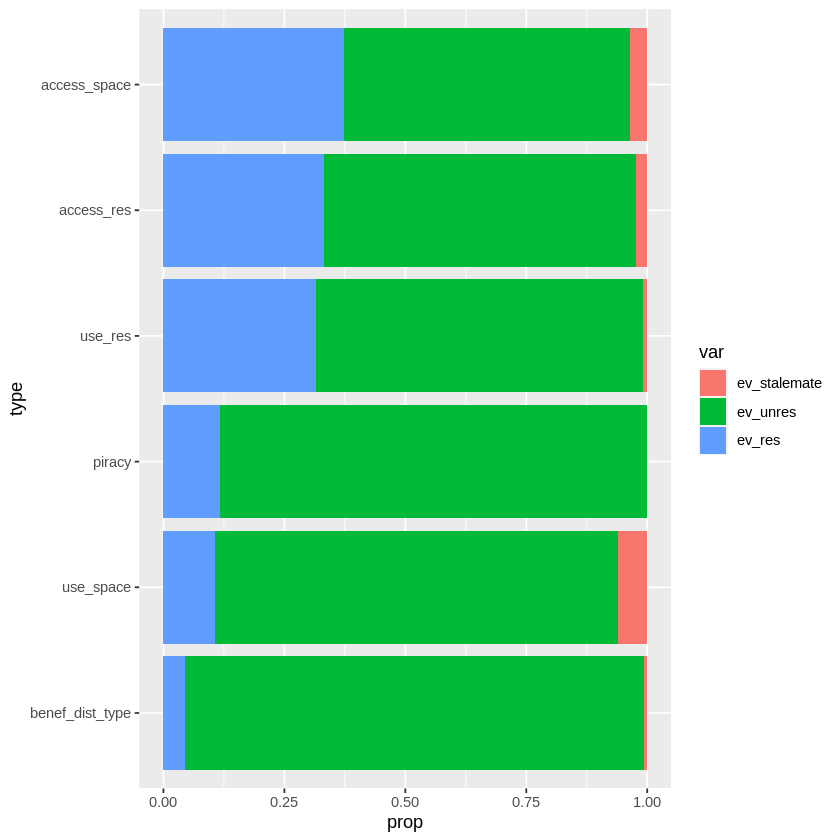

In [ ]:
foo <- df
foo$var <- rownames(foo)

# convert to long
bar <- melt(foo, id.vars='var',
    measure.vars=conflict_type, variable.name="type", value.name="prop")

# reorder
bar$var <- factor(bar$var, levels = rev(c('ev_res', 'ev_unres', 'ev_stalemate')))

x <- bar[bar$var=='ev_res',]
bar$type <- factor(bar$type, levels = x$type[order(x$prop)])

# Stacked + percent
ggplot(bar, aes(fill=var, y=prop, x=type)) +
    geom_bar(position="fill", stat="identity") +
    coord_flip()

ggsave('resolution_conflict.pdf', height = 3, width = 5)

Stats

In [ ]:
# conflict type
df_list <- map(conflict_type, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(resolution_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = resolution_type, count = colSums(.)))

df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- df$var
df <- df %>% select(-var)
colnames(df) <- conflict_type


# comnine solved and stalemate
foo <- as.data.frame(t(df))
foo$unresolved <- foo$ev_unres
foo$resolved <- foo$ev_stalemate + foo$ev_res
foo <- foo[c('resolved', 'unresolved')]

test <- chisq.test(foo)
test$statistic
test$parameter
test$p.value

X-squared 
 89.93883

df 
 5

[1] 6.921112e-18

In [ ]:
# major actors
actor_type_selected <- c('subs_fisher', 'ind_fishers', 'intl_govt', 'state_enf')

df_list <- map(actor_type_selected, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(resolution_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = resolution_type, count = colSums(.)))

df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- df$var
df <- df %>% select(-var)
colnames(df) <- actor_type_selected


# comnine solved and stalemate
foo <- as.data.frame(t(df))
foo$unresolved <- foo$ev_unres
foo$resolved <- foo$ev_stalemate + foo$ev_res
foo <- foo[c('resolved', 'unresolved')]

test <- chisq.test(foo)
test$statistic
test$parameter
test$p.value

X-squared 
 155.3299

df 
 3

[1] 1.86581e-33

Resolution by actors

In [ ]:
df_list <- map(actor_type_selected, ~ data %>%
    filter(!(piracy == 1 & total_conflict == 1)) %>%
    filter(.data[[.x]] == 1) %>%
    select(all_of(resolution_type)) %>%
    mutate_all(as.numeric) %>%
    reframe(var = resolution_type, count = colSums(.)))

df <- reduce(df_list, full_join, by = 'var')

df <- as.data.frame(df)
rownames(df) <- df$var
df <- df %>% select(-var)
colnames(df) <- actor_type_selected
df <- sweep(df, 2, colSums(df), `/`)
df

,subs_fisher,ind_fishers,intl_govt,state_enf
,<dbl>,<dbl>,<dbl>,<dbl>
ev_stalemate,0.03632479,0.01259446,0.03519062,0.04371585
ev_res,0.26068376,0.38035264,0.23313783,0.59562842
ev_unres,0.70299145,0.60705290,0.73167155,0.36065574


bar chart

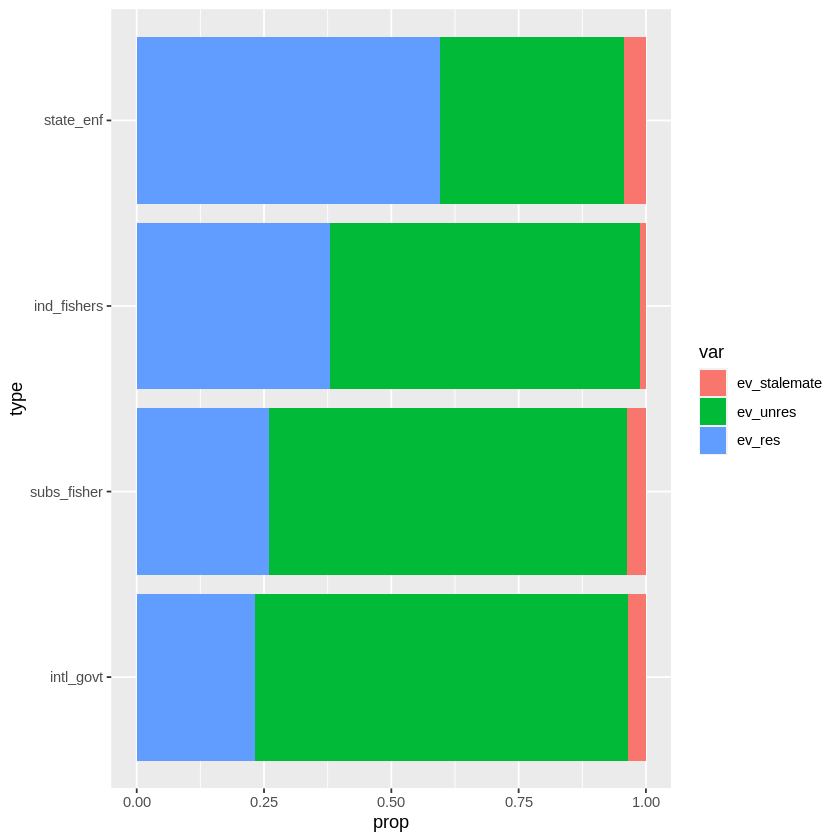

In [ ]:
foo <- df
foo$var <- rownames(foo)

# convert to long
bar <- melt(foo, id.vars='var',
    measure.vars=actor_type_selected , variable.name="type", value.name="prop")

# reorder
bar$var <- factor(bar$var, levels = rev(c('ev_res', 'ev_unres', 'ev_stalemate')))

x <- bar[bar$var=='ev_res',]
bar$type <- factor(bar$type, levels = x$type[order(x$prop)])

# Stacked + percent
ggplot(bar, aes(fill=var, y=prop, x=type)) +
    geom_bar(position="fill", stat="identity") +
    coord_flip()

ggsave('resolution_actor.pdf', height = 2, width = 5)

# Path to resolution

In [ ]:
path_to_resolution_type <- c('ev_res_conf_med', 'ev_res_inc_gov', 'ev_leg_court_res', 'ransom')

foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(ev_res==1) %>%
    select(all_of(path_to_resolution_type)) %>%
    mutate_all(~ifelse(.x > 0, 1, 0)) %>%
    mutate(x = rowSums(.))

nrow(foo[foo$x > 0, ])/nrow(foo)

[1] 0.9285714

In [ ]:
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(ev_res==1) %>%
    select(all_of(path_to_resolution_type)) %>%
    mutate_all(~ifelse(.x > 0, 1, 0)) %>%
    reframe(var = path_to_resolution_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total)


var,count,total,prop
<chr>,<dbl>,<int>,<dbl>
ev_res_conf_med,23,294,0.07823129
ev_res_inc_gov,219,294,0.74489796
ev_leg_court_res,60,294,0.20408163
ransom,0,294,0.00000000


Only the factor

In [ ]:
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(ev_res==1) %>%
    select(all_of(path_to_resolution_type)) %>%
    mutate_all(~ifelse(.x > 0, 1, 0)) %>%
    mutate(x = rowSums(.))

only_factor <- foo[foo$ev_res_inc_gov == 1 & foo$x == 1,]
part_factor <- foo[foo$ev_res_inc_gov == 1 & foo$x > 0,]

nrow(only_factor)/nrow(part_factor)

[1] 0.8949772

In [ ]:
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(ev_res==1) %>%
    select(all_of(path_to_resolution_type)) %>%
    mutate_all(~ifelse(.x > 0, 1, 0)) %>%
    mutate(x = rowSums(.))

only_factor <- foo[foo$ev_leg_court_res == 1 & foo$x == 1,]
part_factor <- foo[foo$ev_leg_court_res == 1 & foo$x > 0,]

nrow(only_factor)/nrow(part_factor)

[1] 0.5833333

Other

In [ ]:
# Benefit distribution as a conflict type & a driver
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    select(benef_dist_type, benef_dist_driv)


nrow(foo[foo$benef_dist_type == 1 & foo$benef_dist_driv == 1,])/nrow(foo[foo$benef_dist_type == 1,])

[1] 0.858209

In [ ]:
# small-scale fisher as actor & benefit distribution as a driver
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    select(subs_fisher, benef_dist_driv)

nrow(foo[foo$subs_fisher == 1 & foo$benef_dist_driv == 1,])/nrow(foo[foo$benef_dist_driv == 1,])

[1] 0.6666667

In [ ]:
# small-scale fisher as actor & benefit distribution as a driver
foo <- data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    select(subs_fisher, benef_dist_type)

nrow(foo[foo$subs_fisher == 1 & foo$benef_dist_type == 1,])/nrow(foo[foo$benef_dist_type == 1,])

[1] 0.7462687

In [ ]:
# actors associated with increased governance or enforcement (ev_res_inc_gov) as path to resolution
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    mutate_at(path_to_resolution_type, ~ifelse(.x > 0, 1, 0)) %>%
    filter(ev_res_inc_gov == 1) %>%
    select(all_of(actor_type_original)) %>%
    reframe(actor = actor_type_original, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(prop))

actor,count,total,prop
<chr>,<dbl>,<int>,<dbl>
state_enf,183,219,0.83561644
ind_fishers,134,219,0.61187215
intl_govt,108,219,0.49315068
subs_fisher,80,219,0.36529680
intl_ngo,19,219,0.08675799
loc_govt,19,219,0.08675799
intl_multi_bod,18,219,0.08219178
natl_ngo,13,219,0.05936073
fish_trad,11,219,0.05022831


In [ ]:
# path to resolution for small-scale fishers
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(subs_fisher == 1 & ev_res == 1) %>%
    mutate_at(path_to_resolution_type, ~ifelse(.x > 0, 1, 0)) %>%
    select(all_of(path_to_resolution_type)) %>%
    reframe(p2r = path_to_resolution_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(prop))

p2r,count,total,prop
<chr>,<dbl>,<int>,<dbl>
ev_res_inc_gov,80,122,0.6557377
ev_leg_court_res,21,122,0.1721311
ev_res_conf_med,18,122,0.1475410
ransom,0,122,0.0000000


In [ ]:
# path to resolution for industrial fishers
data %>%
    filter(!(piracy==1 & total_conflict==1)) %>%
    filter(ind_fishers == 1 & ev_res == 1) %>%
    mutate_at(path_to_resolution_type, ~ifelse(.x > 0, 1, 0)) %>%
    select(all_of(path_to_resolution_type)) %>%
    reframe(p2r = path_to_resolution_type, count = colSums(.), total = nrow(.)) %>%
    mutate(prop = count/total) %>%
    arrange(desc(prop))

p2r,count,total,prop
<chr>,<dbl>,<int>,<dbl>
ev_res_inc_gov,134,151,0.8874172
ev_leg_court_res,24,151,0.1589404
ev_res_conf_med,6,151,0.0397351
ransom,0,151,0.0000000
